In [7]:
from typing import Optional, List, Tuple
import torch
import time
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm, colors
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker
import matplotlib.patheffects as pe

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "STIXGeneral",
    "text.latex.preamble": r"\usepackage[utf8]{inputenc}\usepackage{amsmath}",
    "figure.figsize": [12, 4],  # ancho, Largo  
    "xtick.labelsize": 12,  # tamaño ticks en eje x
    "ytick.labelsize": 12   # tamaño ticks en eje y
})

import numpy as np
import pandas as pd
import numpy as np
import random


import os                          # Import operating system interface
import win32com.client as win32    # Import COM

import botorch
import torch
from botorch.models import SingleTaskGP, ModelListGP
from botorch.optim import optimize_acqf
from botorch import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
import torch.nn as nn
import torch.nn.functional as F
from botorch.models.transforms import Normalize, Standardize
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch.acquisition import UpperConfidenceBound, ExpectedImprovement
from botorch.sampling import SobolQMCNormalSampler
from botorch.utils.multi_objective.box_decompositions.non_dominated import (
    FastNondominatedPartitioning)

import pymoo
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting



In [14]:
print( pd.__version__  ) 

2.2.3


In [2]:
seed = 42
random.seed(seed) # random seed for Python's random module
np.random.seed(seed) # random seed for NumPy
torch.manual_seed(seed) # random seed for PyTorch

Generar puntos usados para el encoder (training set )

In [3]:
def data_encoder_generation(bounds, num_initial_points,seed = 42):
    """
    :parambounds: Tensor de límites de las variables.
    :param num_initial_points: Número de puntos iniciales a generar.
    :param satisface_constraints: Función que verifica si un punto satisface las restricciones.
    :regresar: Resultados
    """
    # Deterministic behaviour
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    initial_points = []
    while len(initial_points) < num_initial_points:
        candidate_point = []
        for i in range(bounds.shape[1]): 
            value = torch.randint(bounds[0, i].to(torch.int).item(), bounds[1, i].to(torch.int).item() + 1, (1,)).item()
            candidate_point.append(value)           
        if satisfies_constraints_discrete(candidate_point):
            initial_points.append(candidate_point)
    return torch.tensor(initial_points, dtype=torch.float64)

# Constraint variables
def satisfies_constraints_discrete(x):
    Constraint_List = []
    Constraint_List.append(x[0]<x[1])
    Constraint_List.append(x[0]<x[2]) #  Feed stage solvent < NT dividing wall 
    Constraint_List.append(x[1]<x[2]) #  Feed stage azeotropic < NT dividing wall
    Constraint_List.append(x[2]< (x[3]-3) ) # NT dividing wall < NT total stages  
    Feasibility = all(Constraint_List) == True    # True if all constraints are True, False if one value doesnt meet the criterion
    return Feasibility

bounds = torch.tensor([[1 , 1 , 1 , 30] ,
                       [60, 60, 60, 50]],dtype = torch.float64)
num_initial_points = 5000
initial_points = data_encoder_generation(bounds , num_initial_points=num_initial_points)
print('Number of points generated:', len(initial_points))
initial_points

Number of points generated: 5000


tensor([[ 5., 14., 29., 35.],
        [ 4.,  8., 39., 47.],
        [ 2., 20., 42., 50.],
        ...,
        [ 7., 11., 30., 37.],
        [13., 24., 26., 32.],
        [ 6.,  8., 10., 44.]], dtype=torch.float64)

In [4]:
columns_to_encode = initial_points
X_discrete_raw = columns_to_encode.clone()


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VariationalAutoencoder(nn.Module):
    def __init__(self, emb_dim=8,   hidden_dim = 64 ,  latent_dim=8):
        super().__init__()
        self.emb_dim = emb_dim
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim

        # Embeddings for each discrete variable
        self.feed1_emb = nn.Embedding(60, emb_dim) 
        self.feed2_emb = nn.Embedding(60, emb_dim)  
        self.stagesdw_emb = nn.Embedding(60, emb_dim)  
        self.stagescol_emb = nn.Embedding(21, emb_dim) 

        # Encoder y decoder
        encoder_sizes = [4 * emb_dim, hidden_dim, hidden_dim // 2, hidden_dim // 4]
        self.encoder_fc  = nn.Sequential(
            nn.Linear(encoder_sizes[0], encoder_sizes[1]),
            nn.LeakyReLU(0.01),
            nn.Linear(encoder_sizes[1], encoder_sizes[2]),
            nn.LeakyReLU(0.01),
            nn.Linear(encoder_sizes[2], encoder_sizes[3]),
        )
        self.fc_mu = nn.Linear(encoder_sizes[-1], latent_dim)
        self.fc_logvar = nn.Linear(encoder_sizes[-1], latent_dim)

        decoder_sizes = encoder_sizes[::-1]
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, decoder_sizes[0]),
            nn.LeakyReLU(0.01),
            nn.Linear(decoder_sizes[0], decoder_sizes[1]),
            nn.LeakyReLU(0.01),
            nn.Linear(decoder_sizes[1], decoder_sizes[2]),
            nn.LeakyReLU(0.01),
            nn.Linear(decoder_sizes[2], decoder_sizes[3])
        )

        # Individual decoders per variable
        self.feed1_out = nn.Linear(emb_dim, 60)
        self.feed2_out = nn.Linear(emb_dim, 60)
        self.stagesdw_out = nn.Linear(emb_dim, 60)
        self.stagescol_out = nn.Linear(emb_dim, 21)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def recover(self, z_space_predicted):

        y_decoded = self.decoder(z_space_predicted).squeeze(0)
        # Separate the decoder outputs for each variable
        f1_dec, f2_dec, dw_dec, col_dec = torch.chunk(y_decoded, 4, dim=1)
        f1_logits = self.feed1_out(f1_dec)
        f2_logits = self.feed2_out(f2_dec)
        dw_logits = self.stagesdw_out(dw_dec)
        col_logits = self.stagescol_out(col_dec)


        # Apply softmax to obtain probabilities
        f1_probs = F.softmax(f1_logits, dim=1)
        f2_probs = F.softmax(f2_logits, dim=1)
        dw_probs = F.softmax(dw_logits, dim=1)
        col_probs = F.softmax(col_logits, dim=1)

        # Obtain the indexes with the highest probability (discrete values)
        f1_discrete = torch.argmax(f1_probs, dim=1) + 1  
        f2_discrete = torch.argmax(f2_probs, dim=1) + 1  
        dw_discrete = torch.argmax(dw_probs, dim=1) + 1  
        col_discrete = torch.argmax(col_probs, dim=1) + 30
        return f1_discrete, f2_discrete, dw_discrete, col_discrete
    
    def forward(self, x):
        # x: batch x 3
        f1, f2, dwstages , nstages = x[:, 0], x[:, 1], x[:, 2] , x[:, 3]

        # Adjust indexes to 0-based
        f1_idx = f1 - 1
        f2_idx = f2 - 1
        dw_stage_idx = dwstages - 1
        colum_stage_ind = nstages - 30

        # Embeddings
        f1_emb = self.feed1_emb(f1_idx)
        f2_emb = self.feed2_emb(f2_idx)
        dw_emb = self.stagesdw_emb(dw_stage_idx)
        col_emb = self.stagescol_emb(colum_stage_ind) 

        h = torch.cat([f1_emb, f2_emb, dw_emb, col_emb], dim=1)
        h_enc = self.encoder_fc(h)

        mu = self.fc_mu(h_enc)
        logvar = self.fc_logvar(h_enc)
        z = self.reparameterize(mu, logvar)

        h_dec = self.decoder(z)

        # Separate representation and decode each variable
        f1_dec, f2_dec, dw_dec, col_dec  = torch.chunk(h_dec, 4, dim=1)

        f1_logits = self.feed1_out(f1_dec)
        f2_logits = self.feed2_out(f2_dec)
        dw_logits = self.stagesdw_out(dw_dec)
        col_logits = self.stagescol_out(col_dec)
        return f1_logits, f2_logits, dw_logits , col_logits,  mu, logvar
    


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VariationalAutoencoder(emb_dim=71, hidden_dim = 115 ,  latent_dim=7).to(device)
checkpoint = torch.load('VAE_Intensified.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

VariationalAutoencoder(
  (feed1_emb): Embedding(60, 71)
  (feed2_emb): Embedding(60, 71)
  (stagesdw_emb): Embedding(60, 71)
  (stagescol_emb): Embedding(21, 71)
  (encoder_fc): Sequential(
    (0): Linear(in_features=284, out_features=115, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=115, out_features=57, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=57, out_features=28, bias=True)
  )
  (fc_mu): Linear(in_features=28, out_features=7, bias=True)
  (fc_logvar): Linear(in_features=28, out_features=7, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=7, out_features=28, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=28, out_features=57, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=57, out_features=115, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=115, out_features=284, bias=True)
  )
  (feed1_out): Linear(in_

Test if initial data can be reconstructed with accuracy

In [7]:

sample =  X_discrete_raw[0:4500].to(dtype=torch.long) #  torch.tensor([[14, 30, 42]])
with torch.no_grad():
    # Adjust indexes for embeddings
    f1_idx = sample[:, 0] - 1
    f2_idx = sample[:, 1] - 1
    dw_idx = sample[:, 2] - 1
    col_idx = sample[:,3] - 30

    # Get embeddings
    f1_emb = model.feed1_emb(f1_idx)
    f2_emb = model.feed2_emb(f2_idx)
    dw_emb = model.stagesdw_emb(dw_idx)
    col_emb = model.stagescol_emb(col_idx)

    # Concatenate embeddings and pass through the encoder
    h = torch.cat([f1_emb, f2_emb, dw_emb, col_emb], dim=1)
    h_enc = model.encoder_fc(h)
    mu = model.fc_mu(h_enc)
    logvar = model.fc_logvar(h_enc)
    z_train = model.reparameterize(mu, logvar)

    # Pass z through the decoder
    y_decoded = model.decoder(z_train)

    # Separate the decoder outputs for each variable
    f1_dec, f2_dec, dw_dec, col_dec = torch.chunk(y_decoded, 4 , dim=1)
    f1_logits = model.feed1_out(f1_dec)
    f2_logits = model.feed2_out(f2_dec) 
    dw_logits = model.stagesdw_out(dw_dec)
    col_logits = model.stagescol_out(col_dec)


    # Apply softmax to obtain probabilities
    f1_probs = F.softmax(f1_logits, dim=1)
    f2_probs = F.softmax(f2_logits, dim=1)
    dw_probs = F.softmax(dw_logits, dim=1)
    col_probs = F.softmax(col_logits, dim = 1)

    # Adjust indexes
    f1_discrete = torch.argmax(f1_probs, dim=1) + 1  
    f2_discrete = torch.argmax(f2_probs, dim=1) + 1 
    dw_discrete = torch.argmax(dw_probs, dim=1) + 1  
    col_discrete = torch.argmax(col_probs, dim=1) + 30

# Combine discrete variables into a tensor
discrete_values = torch.cat([f1_discrete.unsqueeze(1), f2_discrete.unsqueeze(1),
                            dw_discrete.unsqueeze(1), col_discrete.unsqueeze(1) ], dim=1)

print("Discrete values recovered:", discrete_values)


Discrete values recovered: tensor([[ 5, 14, 29, 35],
        [ 4,  8, 39, 47],
        [ 2, 20, 42, 50],
        ...,
        [ 8, 22, 24, 47],
        [13, 27, 31, 41],
        [17, 26, 28, 50]])


In [8]:
# bound
min_bounds, max_bounds = [] , []
for i in range(z_train.shape[1]):
    min_bounds.append(z_train[:,i].min().item())
    max_bounds.append(z_train[:,i].max().item())
print('min_bounds',min_bounds)
print('max_bounds',max_bounds)

min_bounds [-3.0965192317962646, -3.1039211750030518, -3.0956649780273438, -3.336411476135254, -2.959186553955078, -3.2384085655212402, -2.6042728424072266]
max_bounds [3.4380059242248535, 2.471174955368042, 3.077383518218994, 2.6739861965179443, 2.9803311824798584, 2.6005043983459473, 2.7932982444763184]


### Begin B.O.

In [21]:

def population_generation(bounds, var_types, num_initial_points,seed = 42):
    """
    :param bounds: Bounds tensor for the variables.
    :param num_initial_points: Number of initial points to generate.
    :param satisfies_constraints: Function that checks whether a point satisfies the constraints.
    :return: Results
    """
    # Deterministic behaviour
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    initial_points = []

    while len(initial_points) < num_initial_points:
        candidate_point = []
        for i in range(len(var_types)): 
            if var_types[i] == 'real':
                value = torch.rand(1).item() * (bounds[1, i] - bounds[0, i]) + bounds[0, i]
            elif var_types[i] == 'int':
                value = torch.randint(bounds[0, i].to(torch.int).item(), bounds[1, i].to(torch.int).item() + 1, (1,)).item()
            candidate_point.append(value)
        if satisfies_constraints(candidate_point):
            initial_points.append(candidate_point)
    return torch.tensor(initial_points, dtype=torch.float64)

# Constrains
def satisfies_constraints(x):
    Constraint_List = []
    Constraint_List.append(x[3]<x[4]) 
    Constraint_List.append(x[3]<x[5]) 
    Constraint_List.append(x[4]<x[5]) 
    Constraint_List.append(x[5]< (x[6]-3))
    Feasibility = all(Constraint_List) == True    
    return Feasibility

# Manipulated variables
#                       Re, S/F, Vr, F1, F2, NDWT, NCT 
bounds = torch.tensor([[2.0, 50 , 15 ,1 , 1 , 1, 30] ,
                       [5.0, 100, 100 , 50, 50, 50, 50]],dtype = torch.float64)
var_types = ['real', 'real', 'real', 'int', 'int', 'int', 'int']

# Get initial points
num_initial_points = 50
initial_points_BO = population_generation(bounds, var_types , num_initial_points=num_initial_points)
print('Number of points generated:', len(initial_points_BO))

Number of points generated: 50


In [22]:
# Discrete variables, format must be changed to long or int type
continuos_initial_points = initial_points_BO[:, 0:3].numpy()
discrete_initial_points = torch.tensor(np.array(initial_points_BO[:, 3:]),dtype=torch.long)
with torch.no_grad():
    # Adjust indexes for embeddings
    f1_idx = discrete_initial_points[:, 0] - 1
    f2_idx = discrete_initial_points[:, 1] - 1
    dw_idx = discrete_initial_points[:, 2] - 1
    col_idx = discrete_initial_points[:,3] - 30 
    # Get embeddings
    f1_emb = model.feed1_emb(f1_idx)
    f2_emb = model.feed2_emb(f2_idx)
    dw_emb = model.stagesdw_emb(dw_idx)
    col_emb = model.stagescol_emb(col_idx)

    # Concatenate embeddings and pass through the encoder
    h = torch.cat([f1_emb, f2_emb, dw_emb, col_emb], dim=1)
    h_enc = model.encoder_fc(h)

    mu = model.fc_mu(h_enc)
    logvar = model.fc_logvar(h_enc)
    z_new =  model.reparameterize(mu, logvar)
# Concatenate continuous variables with new latent space
converted_points = torch.tensor(np.hstack( (continuos_initial_points, z_new) ))
# converted_points

Aspen Class that takes and calculates all the data required for B.O.

In [ ]:

class AspenSimulation:
    
    def __init__(self, aspen_file_path, output_nodes, listofcomponents):
        """
        Initializes the connection to ASPEN and sets the paths for variables and outputs.

        :param aspen_file_path: Path to the ASPEN file.
        :param variable_nodes: List of paths for variables in ASPEN.
        :param output_nodes: List of paths for outputs in ASPEN.
        """
        self.aspen_file_path = os.path.abspath(aspen_file_path)
        self.output_nodes = output_nodes
        self.listofcomponents = listofcomponents
        self.aspen = None

    def connect(self):
        import win32com.client as win32 
        """Connect to ASPEN and load the simulation"""
        self.aspen = win32.Dispatch("Apwn.Document") # .client.Dispatch("Apwn.Document")
        self.aspen.InitFromFile(self.aspen_file_path)
        self.aspen.Visible  = False
        self.aspen.SuppressDialogs = True
        time.sleep(2)
        self.aspen.Engine.Run2()
        time.sleep(2)

    def Antoine_function(self,Antoine1,Antoine2,Antoine3,Antoine4,Antoine5,Antoine6,Antoine7,T):
        ListPsat = [] #np.zeros(componentes)
        for i in range(len(Antoine1)):
            ListPsat.append(np.exp(Antoine1[i] + Antoine2[i]/(T+Antoine3[i]) + Antoine4[i]*T + Antoine5[i]*np.log(T) +  Antoine6[i]*T**Antoine7[i]))
        return np.array(ListPsat)

    def Antoine_values(self, listofcomponents):
        # Parameters for vapor pressure (Extended Antoine)
        listofvalues = ['VAL1','VAL2','VAL3','VAL4','VAL5','VAL6','VAL7']  #Default values given in Aspen
        listA, listB, listC, listD, listE, listF, listG = [],[],[],[],[],[],[]
        for i in listofvalues:
            for j in listofcomponents:
                path_constants = r"\Data\Properties\Parameters\Pure Components\PLXANT-1\Input\{value}\PLXANT\{comp}".format(value= i, comp = j)
                if i == 'VAL1':
                    listA.append(float(self.aspen.Tree.FindNode(path_constants).Value))
                elif i == 'VAL2':
                    listB.append(float(self.aspen.Tree.FindNode(path_constants).Value))
                elif i == 'VAL3':
                    listC.append(float(self.aspen.Tree.FindNode(path_constants).Value))
                elif i == 'VAL4':
                    listD.append(float(self.aspen.Tree.FindNode(path_constants).Value))
                elif i == 'VAL5':
                    listE.append(float(self.aspen.Tree.FindNode(path_constants).Value))
                elif i == 'VAL6':
                    listF.append(float(self.aspen.Tree.FindNode(path_constants).Value))
                elif i == 'VAL7':
                    listG.append(float(self.aspen.Tree.FindNode(path_constants).Value))  
        return listA, listB, listC, listD, listE, listF, listG

    def EnthalpyCombustion(self, listofcomponents):
        # Enthalpys of combustion from aspen in cal/mol
        listHcom = []
        for i in listofcomponents:
            dic = r"\Data\Properties\Parameters\Pure Components\REVIEW-1\Input\VALUE\HCOM\{comp}"
            Hcom = float(self.aspen.Tree.FindNode(dic.format(comp = i)).Value)/1000  #cal/mol a kcal/mol 
            Hcom = Hcom*4184  #J/mol
            listHcom.append(Hcom) 
        return  np.array(listHcom)

    def variables_FEDI(self,listofcomponents, nt1):
        x_in1 , x_in2, x_ins, x_in3, Ts = [] , [], [], [] , []
        Feed_1_dir = r"\Data\Streams\FEED\Input\FLOW\MIXED\{comp}" 
        Feed_2_dir = r"\Data\Streams\SOLVENT\Input\FLOW\MIXED\{comp}"
        for i in listofcomponents:
            # Extract molar composition information of stream 1
            if self.aspen.Tree.FindNode(Feed_1_dir.format(comp = i)).Value == None:
                x_in1.append(0.00)
            else:
                x_in1.append(self.aspen.Tree.FindNode(Feed_1_dir.format(comp = i)).Value)
            # Extract molar composition information of stream 2
            if self.aspen.Tree.FindNode(Feed_2_dir.format(comp = i)).Value == None:
                x_in2.append(0.00)
            else:
                x_in2.append(self.aspen.Tree.FindNode(Feed_2_dir.format(comp = i)).Value) 
            # Bottom streams form column 1 entering in column 2 
            x_in3.append(self.aspen.Tree.FindNode(r"\Data\Blocks\B1\Output\X\{nts}\{comp}".format(nts = str(int(nt1)), comp = str(i) )).Value)
        # Normalize the composition of both streams entering in the column 
        F1 = self.aspen.Tree.FindNode(r"\Data\Streams\FEED\Input\TOTFLOW\MIXED").Value
        F2 = self.aspen.Tree.FindNode(r"\Data\Streams\SOLVENT\Input\TOTFLOW\MIXED").Value
        T_in_1 = self.aspen.Tree.FindNode(r"\Data\Streams\5\Output\TEMP_OUT\MIXED").Value + 273.15 #[K]
        T_in_2 = self.aspen.Tree.FindNode(r"\Data\Streams\3\Output\TEMP_OUT\MIXED").Value + 273.15 #[K]
        x_ins.append( ((np.array(F1)*np.array(x_in1)   +   np.array(F2)*np.array(x_in2)) / (F1+F2)) )
        #Mean Temperature between solvent and azeotropic mixture
        Ts.append((T_in_1+T_in_2)/2) 
        # Temperature of bottom of first column
        Ts.append(self.aspen.Tree.FindNode(r"\Data\Blocks\{block}\Output\BOTTOM_TEMP".format(block = 'B1')).Value + 273.15 ) 
        # Composition of bottom stream 
        x_ins.append(np.array(x_in3))
        return x_ins,  Ts
    
    def Fedi(self, tags, listofcomponents, NF, NR, x_ins, Ts, d, nt, FlashPoint_val, IgnitionTemperature_val):
        # Enthalpys of combustion from aspen in cal/mol
        listHcom = self.EnthalpyCombustion(listofcomponents)
        # Parameters for vapor pressure (Extended Antoine)
        listA, listB, listC, listD, listE, listF, listG = self.Antoine_values(listofcomponents)
        # Calculations of fedi for each column
        x_in = x_ins[0]
        block_tag = tags[0]
        T  = Ts[0]
        FlashPoint = sum(FlashPoint_val*x_in)
        AutoIgnitionTemp = sum(IgnitionTemperature_val*x_in)
        Vol = (np.pi * ( d/2)**2)*(1.2*0.61*(nt-2))  # [m3]
        Pcolumn = float(self.aspen.Tree.FindNode(r"\Data\Blocks\{block}\Input\PRES1".format(block=block_tag)).Value*101.325)  # [atm a kPa]
        Mass =  float(self.aspen.Tree.FindNode(r"\Data\Blocks\{block}\Output\BAL_MASI_TFL".format(block=block_tag)).Value/3600)  # [Kg/sec]
        Treb = self.aspen.Tree.FindNode(r"\Data\Blocks\{block}\Output\BOTTOM_TEMP".format(block=block_tag)).Value + 273.15 # Celsius to Kelvyn
        #---------------F1,F2,F3,F4-----------------#
        Entalpy_comb = sum(abs(listHcom)*x_in )  # [KJ/mol] 
        
        F1 = 0.1*(Mass*(Entalpy_comb))/3.148
        F2 = (6/3.148)*Pcolumn*Vol
        Psat_in = self.Antoine_function(listA,listB, listC, listD, listE, listF, listG, T)*100 # [Bar a kPa]
        VapPress = sum(Psat_in*x_in )
        F3 = (1e-3)*(1/Treb)*((Pcolumn-VapPress)**2)*Vol   
        # Penalty 1
        if T > FlashPoint and T < 0.75*AutoIgnitionTemp: 
            pn1 = (1.45 +  1.75)/2
        elif T > 0.75*AutoIgnitionTemp:
            pn1 = 1.95
        else:
            pn1 = 1.1
        # Penalty 2
        if VapPress > 101.325 and Pcolumn > VapPress :
            pn2 = 1 + (Pcolumn-VapPress)*0.6/Pcolumn
            F = F2 + F3
        else:
            pn2 = 1 + (Pcolumn-VapPress)*0.4/Pcolumn
            F = F2
        if VapPress < 101.325 and 101.325 < Pcolumn:
            pn2 = 1 + (Pcolumn-VapPress)*0.2/Pcolumn
            F = F3
        else:
            pn2 = 1.1
            F = F3     
        # Penalty 4
        pn4 = 1 + 0.25*(np.array(NF).max() + np.array(NR).max())
        pn3,pn5,pn6 = 1,1,1
        Damage_Potential = (F1*pn1 + F*pn2)*(pn3*pn4*pn5*pn6)
        Fedi_val = 4.76*(Damage_Potential**(1/3)) 
        return Fedi_val

    def Feasibily_Check(self, x):
        Constraint_List = []
        Constraint_List.append(x[3]<x[4]) 
        Constraint_List.append(x[3]<x[5]) 
        Constraint_List.append(x[4]<x[5]) 
        Constraint_List.append(x[5]< (x[6]-3)) 
        Feasibility = all(Constraint_List) == True   
        return Feasibility

    def Update_Aspen(self,x):
        #-----------------------------Column 1-----------------------------#
        N_C1 = r"\Data\Blocks\B1\Input\NSTAGE"
        RR_C1  = r"\Data\Blocks\B1\Input\BASIS_RR"
        solvent_flow_rate = r"\Data\Streams\SOLVENT\Input\TOTFLOW\MIXED"
        FeedStage_1  = r"\Data\Blocks\B1\Input\FEED_STAGE\3"  
        FeedStage_2 = r"\Data\Blocks\B1\Input\FEED_STAGE\5"
        vapor_flow = r"\Data\Blocks\B1\Input\PROD_FLOW\VR"
        #Send to Aspen #
        self.aspen.Tree.FindNode(N_C1).Value = x[6] 
        self.aspen.Tree.FindNode(RR_C1).Value = x[0] 
        self.aspen.Tree.FindNode(solvent_flow_rate).Value = x[1] 
        self.aspen.Tree.FindNode(FeedStage_1).Value = x[3]   
        self.aspen.Tree.FindNode(FeedStage_2).Value = x[4]
        self.aspen.Tree.FindNode(vapor_flow).Value = x[2]
        # Internals of column 1
        B1_INT_1 = r"\Data\Blocks\B1\Subobjects\Column Internals\INT-1\Input\CA_STAGE2\INT-1\INT"
        self.aspen.Tree.FindNode(B1_INT_1).Value = x[6] - 1  # Actualizar internals de primera columna


        #-----------------------------Column 2-----------------------------#
        N_C2 = r"\Data\Blocks\B2\Input\NSTAGE"
        #Send to Aspen #
        self.aspen.Tree.FindNode(N_C2).Value = x[5] # Se alimenta en el fondo de la columna o NT2 
        vapor_source_stage  = r"\Data\Blocks\B1\Input\PROD_STAGE\VR"
        self.aspen.Tree.FindNode(vapor_source_stage).Value = x[5]+1  # A stage below
        liquid_feedstage = r"\Data\Blocks\B1\Input\FEED_STAGE\S1"
        self.aspen.Tree.FindNode(liquid_feedstage).Value = x[5]+1  # A stage below
        vapor_feedstage = r"\Data\Blocks\B2\Input\FEED_STAGE\VR"
        self.aspen.Tree.FindNode(vapor_feedstage).Value = x[5]   # In the final stage
        liquid_product  = r"\Data\Blocks\B2\Input\PROD_STAGE\S1"
        self.aspen.Tree.FindNode(liquid_product).Value = x[5]   # In the final stage
        # Internals of column 2
        B2_INT_1 = r"\Data\Blocks\B2\Subobjects\Column Internals\INT-1\Input\CA_STAGE2\INT-1\INT"
        self.aspen.Tree.FindNode(B2_INT_1).Value = x[5]   

    def Clean_Aspen(self):
        #-----------------------------Column 1-----------------------------#
        N_C1 = r"\Data\Blocks\B1\Input\NSTAGE"
        FeedStage_1  = r"\Data\Blocks\B1\Input\FEED_STAGE\3"  
        FeedStage_2 = r"\Data\Blocks\B1\Input\FEED_STAGE\5"
        #Send to Aspen #
        self.aspen.Tree.FindNode(N_C1).Value = 60
        self.aspen.Tree.FindNode(FeedStage_1).Value = 1  
        self.aspen.Tree.FindNode(FeedStage_2).Value = 2
        # Internals of column 1
        B1_INT_1 = r"\Data\Blocks\B1\Subobjects\Column Internals\INT-1\Input\CA_STAGE2\INT-1\INT"
        self.aspen.Tree.FindNode(B1_INT_1).Value = 60 - 1  


        #-----------------------------Column 2-----------------------------#
        N_C2 = r"\Data\Blocks\B2\Input\NSTAGE"
        #Send to Aspen #
        self.aspen.Tree.FindNode(N_C2).Value = 30 # Se alimenta en el fondo de la columna o NT2 
        vapor_source_stage  = r"\Data\Blocks\B1\Input\PROD_STAGE\VR"
        self.aspen.Tree.FindNode(vapor_source_stage).Value = 30+1  # A stage below
        liquid_feedstage = r"\Data\Blocks\B1\Input\FEED_STAGE\S1"
        self.aspen.Tree.FindNode(liquid_feedstage).Value = 30+1  # A stage below
        vapor_feedstage = r"\Data\Blocks\B2\Input\FEED_STAGE\VR"
        self.aspen.Tree.FindNode(vapor_feedstage).Value = 30   # In the final stage
        liquid_product  = r"\Data\Blocks\B2\Input\PROD_STAGE\S1"
        self.aspen.Tree.FindNode(liquid_product).Value = 30   # In the final stage
        # Internals of column 2
        B2_INT_1 = r"\Data\Blocks\B2\Subobjects\Column Internals\INT-1\Input\CA_STAGE2\INT-1\INT"
        self.aspen.Tree.FindNode(B2_INT_1).Value = 30   # Actualizar internals de segunda columna

    def Error_Run(self):
        return [0.001, -1000]  # composicion y FEDI

    def B1_Check(self,listofcomponents, nt1 ):
        x_in_check = []
        for i in listofcomponents:
            x_in_check.append(self.aspen.Tree.FindNode(r"\Data\Blocks\B1\Output\X\{nts}\{comp}".format(nts = str(int(nt1)), comp = str(i) )) == None)
        return x_in_check
    
    def B2_Check(self,listofcomponents, nt2 ):
        x_in_check = []
        for i in listofcomponents:
            x_in_check.append(self.aspen.Tree.FindNode(r"\Data\Blocks\B2\Output\X\{nts}\{comp}".format(nts = str(int(nt2)), comp = str(i) )) == None)
        return x_in_check

    def run_simulation(self, variables):
        """
        Runs the simulation in ASPEN with the values ​​of the provided variables.
        :param variables: List or array of values ​​for the variables.
        :return: Array of output results.
        """
        #----------------------Constraints function-------------#
        if self.aspen is None:
            raise RuntimeError("ASPEN is not connected. Call connect() before running a simulation..")
        
        # Before running Aspen, evaluate whether the point is feasible.
        if self.Feasibily_Check(variables) == False: 
            # print('Does not meet restrictions')
            results =  self.Error_Run() 
            return results 
        
         
        self.Clean_Aspen()
        self.Update_Aspen(variables)
        #-Run problem -#
        self.aspen.Engine.Run2()
            
        Run_Status_Dir = r"\Data\Results Summary\Run-Status\Output\UOSSTAT2"
        #First Check if Status return a value
        if self.aspen.Tree.FindNode(Run_Status_Dir) == None:  # This means there was a problem
            results = self.Error_Run()    
            return results
        else:
            Run_Status = self.aspen.Tree.FindNode(Run_Status_Dir).Value  
            B1Check= self.B1_Check(self.listofcomponents, variables[6])
            B2Check= self.B2_Check(self.listofcomponents, variables[5])
            if Run_Status == 9 or Run_Status == 10 or all(B1Check) == True or all(B2Check) == True: # Error in the simulation 
                results =  self.Error_Run() 
                self.aspen.Reinit()
                return results
            else: # Simulation without errors
                results = []
                nt1, nt2 = variables[6].item(), variables[5].item()       # Value of number of stages 
                d1 = self.aspen.Tree.FindNode(r"\Data\Blocks\B1\Subobjects\Column Internals\INT-1\Subobjects\Sections\INT\Input\CA_DIAM\INT-1\INT").Value
                d2 = self.aspen.Tree.FindNode(r"\Data\Blocks\B2\Subobjects\Column Internals\INT-1\Subobjects\Sections\INT\Input\CA_DIAM\INT-1\INT").Value
                        
                c1_mole_frac = r"\Data\Streams\DCM\Output\MOLEFRAC\MIXED\DICHL-01"
                c2_mole_frac = r"\Data\Streams\MEOH\Output\MOLEFRAC\MIXED\METHA-01"
                c3_mole_frac = r"\Data\Streams\DMF\Output\MOLEFRAC\MIXED\N:N-D-01"
                XD1  = self.aspen.Tree.FindNode(c1_mole_frac).Value
                results.append(XD1)
                listofcomponents = ['METHA-01','DICHL-01','N:N-D-01']
                FlashPoint_val = np.array([9 , -4 , 58]) +273.15                 # [K] 
                IgnitionTemperature_val = np.array([ 464, 605, 440]) + 273.15    # [K]
                NF, NR = np.array([3,1,2]),np.array([0,0,0])                     # NFPA values
                x_ins, Ts = self.variables_FEDI(listofcomponents,nt1=nt1)
                Fedi = self.Fedi(['B1'], listofcomponents, NF, NR, x_ins, Ts, max(d1,d2), nt1, FlashPoint_val, IgnitionTemperature_val)
                results.append(-Fedi)
                return results
    
    def close(self):
        """Closes the connection with ASPEN"""
        if self.aspen is not None:
            self.aspen.Close()
            self.aspen = None

Sort data to avoid hugh differences between designs

In [24]:
initial_points_BO = initial_points_BO[initial_points_BO[:, -1].argsort(descending=False)]


Evaluate all points in Aspen 

In [26]:
output_nodes = [r"\Data\Streams\DCM\Output\MOLEFRAC\MIXED\DICHL-01"]       
listofcomponents = ['METHA-01','DICHL-01','N:N-D-01']
Application = AspenSimulation(aspen_file_path="Caso estudio intensificado.bkp",
                        output_nodes=output_nodes, listofcomponents=listofcomponents)
Application.connect()
# Evaluate the function at these initial points
initial_evals = torch.tensor(np.array([Application.run_simulation(point) for point in initial_points_BO]), dtype=torch.float64)
mask = initial_evals[:, 1] > -999
initial_evals = initial_evals[mask]
initial_points_BO = initial_points_BO[mask]
converted_points = converted_points[mask]
print('Max function value O.F 1:', initial_evals[:,1].max().item())
print('Min function value O.F 1:', initial_evals[:,1].min().item())
print('Max function value O.F 2:', initial_evals[:,0].max().item())
print('Min function value O.F 2:', initial_evals[:,0].min().item())
# Close aspen simulation 
Application.close()

Max function value O.F 1: -312.4710766146014
Min function value O.F 1: -391.87731798055427
Max function value O.F 2: 0.999157389
Min function value O.F 2: 0.72523639


Multiobjective class

In [ ]:


class MultiObjectiveBayesianOpt:
    """
    Multi-objective Bayesian Optimization over a mixed design space (x + latent z).

    This class automates:
    - Independent GP training for each objective
    - Pareto front identification (minimization convention handled internally)
    - Point selection based on predictive uncertainty or acquisition functions
    - Iterative data augmentation with external evaluator (e.g., Aspen)

    Parameters
    ----------
        X_init : torch.Tensor       Initial design points of shape (n0, d), where d = 2 + latent_dim (the first 2 are x, the rest are z).
        Y_init : torch.Tensor       Initial objective values ​​of shape (n0, m), with m objectives.
        bounds : torch.Tensor       Tensor of shape (2, d) with lower/upper bounds for each variable (x and z).
        model_enddec : object       Model with `recover(z_batch)` method → ​​returns discrete variables decoded from z.
        obj_names : List[str]       Names of the objective functions .
        latent_dim : int            Dimension of the latent space .
        n_evals : int               Total number of desired objective evaluations (including initial ones).
        method: str                 Selection method: 'std' (Pareto uncertainty), 'UCB', 'EI', or 'qEHV' (EHVI).
        Aspen_Application: object   Handler with `connect()`, `run_simulation(point)`, `close()` methods.
    Attributes
    ----------
        Aspen_Application : object   Connection to the external evaluator (e.g., Aspen).
        n_evals : int                Total evaluation budget.
        X_init : torch.Tensor        Copy of the initial points.
        Y_init : torch.Tensor        Copy of the initial objectives.
        obj_names : List[str]        Objective names.
        bounds : torch.Tensor        Bounds (2, d).
        model_enddec : object        Decoding model z → discrete variables.
        latent_dim : int             Latent dimension.
        method: str                  Selection strategy.
        all_points: torch.Tenso      Cumulative dataset X (n, d).
        all_objectives: torch.Tensor        Cumulative dataset Y (n, m).
        gp_models: List[SingleTaskGP]       GP models (one per objective).
        mlls: List[ExactMarginalLogLikelihood]  MLL losses for GP fitting.
        final_points: Optional[torch.Tensor]    Last candidate cloud evaluated by GPs/acquisition (n_grid, d).
        pareto_front_list: List[pd.DataFrame]   Front tracking history (means and stds) by iterations (for export).
        data_front_list: List[pd.DataFrame]     History of proposed candidates by iterations (for export).
        pareto_front : np.ndarray               Final Pareto front (using internal minimization convention).
        pareto_indices : np.ndarray             Indices of the non-dominated points within `final_points`.
        pareto_std : np.ndarray                 Standard deviations associated with the front end.
        latent_space_BO : List[torch.Tensor]    List of tensors (1, k, latent_dim) with z proposed in iterations.
        tracking_OF1 : List[float]        Best observed value for objective 2 (for consistency with the original code).
        tracking_OF2 : List[float]        Best observed value for objective 1 (for consistency with the original code).
    """

    def __init__(self, X_init, Y_init, bounds, model_enddec,
                 obj_names, latent_dim, n_evals, method, Aspen_Application):
        
        # Initialize Aspen
        self.Aspen_Application = Aspen_Application
        self.Aspen_Application.connect()

        # Additional variables 
        self.n_evals = n_evals
        self.X_init = X_init
        self.all_points = X_init
        self.Y_init = Y_init
        self.all_objectives = Y_init

        self.obj_names = obj_names
        self.bounds = bounds
        self.model_enddec = model_enddec
        self.latent_dim = latent_dim

        # Training data
        self.method = method

        # Pareton front 
        self.pareto_front_list = []
        self.data_front_list = []
        self.final_points: Optional[torch.Tensor] = None

        # Inicializaciones del ciclo
        self.gp_models: List[SingleTaskGP] = []
        self.mlls: List[ExactMarginalLogLikelihood] = []

        # Resultados de Pareto actuales
        self.pareto_front: Optional[np.ndarray] = None
        self.pareto_indices: Optional[np.ndarray] = None
        self.pareto_std: Optional[np.ndarray] = None

         # Tracking iterativo
        self.latent_space_BO: List[torch.Tensor] = []
        self.tracking_OF1: List[float] = []
        self.tracking_OF2: List[float] = []

    def train_gpr_model(self, X: torch.Tensor, Y: torch.Tensor) -> None:
        """Train independent Gaussian Process models for each objective function."""
        self.gp_models = []
        for i in range(Y.shape[1]):
            gp = SingleTaskGP(X, Y[:,i].unsqueeze(1) , 
                                input_transform=Normalize(d=10),
                                outcome_transform=Standardize(m=1))
            self.gp_models.append(gp)
        self.mlls = [ExactMarginalLogLikelihood(m.likelihood, m) for m in self.gp_models]
        for mll in self.mlls:
            fit_gpytorch_mll(mll)

    def prediction_grid_std(self, acqfs: List, batch_size: int = 100,
                             n_samples: int = 5000, ktop: int = 10) -> torch.Tensor:
        
        """
        Evalute the aqcs with the bounds.
        Return: 
        """
        n_dims = self.bounds.shape[1] 

        # Sample uniform random points in each dimension of the bounds
        random_samples = torch.rand(n_samples, n_dims, dtype=torch.float64)
        lower_bounds = self.bounds[0]
        upper_bounds = self.bounds[1]
        scaled_samples = lower_bounds + (upper_bounds - lower_bounds) * random_samples
        self.final_points =  scaled_samples 
        final_points_batched = self.final_points

        batch_size = 100
        acq_values_list = []
        all_indices = []
        offset = 0
        with torch.no_grad():
            for acqf in acqfs:
                local_acq_values  = []
                for i in range(0, final_points_batched.shape[0], batch_size):
                    batch = final_points_batched[i:i + batch_size]  # slice batch
                    acq_vals = acqf(batch)
                    local_acq_values.append(acq_vals.squeeze(-1))

                # Save all values for each aqf
                local_acq_values = torch.cat(local_acq_values, dim=0)
                # Save values ​​in a global list
                acq_values_list.append(local_acq_values)

                # Save all indexes for each aqf
                indices = torch.arange(final_points_batched.shape[0], dtype=torch.long) + offset
                all_indices.append( indices)
                # Update offset to keep indexes different
                offset += final_points_batched.shape[0]
        
        acq_values = torch.cat(acq_values_list, dim=0).squeeze(-1)
        final_points_expanded = final_points_batched.repeat(len(acqfs), 1)  # (A*n_samples, d)
        k = int(min(ktop, acq_values.numel()))
        topk_vals, topk_indices = torch.topk(acq_values, k=k)
        topk_candidates = final_points_expanded[topk_indices]
        return topk_candidates

    def prediction_grid_ehvi(self, acqf, bounds: torch.Tensor, 
                             ktop: int = 10, n_samples: int = 5000,
                             batch_size: int = 100) -> torch.Tensor:
        """
        Evalúa EHVI sobre una grilla de puntos y devuelve los ktop mejores.
        """
        n_dims = self.bounds.shape[1]

        # Generate uniform samples
        random_samples = torch.rand(n_samples, n_dims, dtype=torch.float64)
        lower_bounds = self.bounds[0]
        upper_bounds = self.bounds[1]
        scaled_samples = lower_bounds + (upper_bounds - lower_bounds) * random_samples

        scaled_samples = scaled_samples.double()
        acq_values = []

        with torch.no_grad():
            for i in range(0, n_samples, batch_size):
                batch = scaled_samples[i:i + batch_size]
                vals = acqf(batch.unsqueeze(1))  # EHVI requiere q-batches, así que q=1
                acq_values.append(vals.squeeze(-1))

        acq_values = torch.cat(acq_values, dim=0)
        topk_vals, topk_indices = torch.topk(acq_values, k=ktop)
        topk_candidates = scaled_samples[topk_indices]
        return topk_candidates

    def evaluate_gps_withoutMC(self, n_samples: int = 5000) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Evalute the gps with the bounds.
        Return: 
            all_means: predictions
            all_std: standart deviation for each point
        """
        # Hay que mejorar esta parte del codigo
        n_dims = self.bounds.shape[1]  # número total de variables (dimensiones)

        # Sample uniform random points in each dimension of the bounds
        random_samples = torch.rand(n_samples, n_dims, dtype=torch.float64)
        lower_bounds = self.bounds[0]
        upper_bounds = self.bounds[1]
        scaled_samples = lower_bounds + (upper_bounds - lower_bounds) * random_samples
        self.final_points =  scaled_samples 
        final_points_batched = self.final_points 

        # Generate random indices
        batch_size = 100
        points_gps = []
        points_std = []
        with torch.no_grad():
            for gp in self.gp_models:
                local_mean_values  = []
                local_std_values = []
                for i in range(0, final_points_batched.shape[0], batch_size):
                    batch = final_points_batched[i:i + batch_size]  # slice batch
                    prediction = gp.posterior(batch) #batch.unsqueeze(-1))
                    local_mean_values.append(prediction.mean)
                    local_std_values.append(prediction.stddev.unsqueeze(1))
                # Save values ​​for each bump for each gp
                local_mean_values = torch.cat(local_mean_values, dim=0)
                local_std_values = torch.cat(local_std_values, dim=0)
                # Save the values ​​in a global list
                points_gps.append(local_mean_values)
                points_std.append(local_std_values)
        all_means = torch.cat(points_gps, dim=1).squeeze(-1)
        all_std = torch.cat(points_std, dim=1).squeeze(-1)                  
        return all_means , all_std

    def find_pareto_front(self, all_means: torch.Tensor, 
                          all_stdvs: torch.Tensor,  maximize=True) -> None:
        """
        Identify the Pareto front considering maximization/minimization objectives.

        Args:
            maximize (list of bool, optional): List indicating whether each objective
                                              should be maximized (True) or minimized (False).
                                              If None, assumes all objectives should be maximized.
        """
        self.pareto_front = []
        self.pareto_std = []
        self.pareto_indices = []

        # Convertir tensor a numpy
        F_space = all_means.cpu().numpy().astype(np.float32)

        stds = all_stdvs.cpu().numpy().astype(np.float32)

        F_space[:, 1] = -F_space[:, 1] # Cambiar la carga termica a positiva
        F_space[:, 0] = -F_space[:, 0] # Cambiar la composicion a negativa 

        # Do non-dominated sorting
        nds = NonDominatedSorting()          
        chunk_size = 100
        num_chunks = int(np.ceil(F_space.shape[0] / chunk_size))
        
        # Initialize with the first block
        current_front = F_space[:chunk_size]
        current_stds = stds[:chunk_size]
        current_indices = np.arange(chunk_size)

        #  Save first optimal points, std and indexes.
        front_indices  = nds.do(current_front, only_non_dominated_front=True)
        #  Get the best unmastered designs
        current_front = current_front[front_indices]
        current_stds = current_stds[front_indices]
        current_indices = current_indices[front_indices]

        list_indices = []
        for i in range(1, num_chunks):
            start = i * chunk_size
            end = min((i + 1) * chunk_size, F_space.shape[0])
            chunk = F_space[start:end]
            chunk_stds = stds[start:end]
            chunk_indices = np.arange(start, end)
            # Combines with previous discrete points
            combined = np.vstack([current_front, chunk])
            combined_stds = np.vstack([current_stds, chunk_stds])
            combined_indices = np.concatenate([current_indices, chunk_indices])
            # Go back to look for unmastered points
            reduced_indices = nds.do(combined, only_non_dominated_front=True)
            
            # Update front
            current_front = combined[reduced_indices]
            current_stds = combined_stds[reduced_indices]
            current_indices = combined_indices[reduced_indices]

        self.pareto_front = current_front
        self.pareto_indices = current_indices
        self.pareto_std = current_stds

    def select_uncertain_points(self, evaluation_points: torch.Tensor,
                                 n_points: int = 50) -> torch.Tensor:
        """
        Select points from Pareto front with highest uncertainty.

        Args:
            n_points (int, optional): Number of points to select (default=2)

        Returns:
            np.array: Selected points in scaled coordinates
        """

        # Use uncertainty from first objective for selection
        uncertainty = np.linalg.norm(np.vstack([self.pareto_std[:,i] for i in range(self.pareto_std.shape[1])]).T, axis=1) #  self.pareto_std[:, 0]

        # Ensure we don't request more points than available
        n_points = min(n_points, len(self.pareto_indices))

        # Select points with highest uncertainty
        top_indices = np.argsort(-uncertainty)[:n_points]
        selected_indices = self.pareto_indices[top_indices]
        return evaluation_points[selected_indices]

    def converted_candidates(self):
        # Pass z through the decoder
        z_space_predicted = torch.tensor([self.all_points[:, -self.latent_dim:].numpy()] , dtype=torch.float32)
        f1_discrete, f2_discrete, dw_discrete , col_discrete = self.model_enddec.recover(z_space_predicted)
        
        return torch.cat((self.all_points[:,:3], f1_discrete.unsqueeze(1), 
                          f2_discrete.unsqueeze(1), dw_discrete.unsqueeze(1),
                          col_discrete.unsqueeze(1)), dim=1).numpy()

    def run_optimization(self, maximize=None, n_points_per_iter: int = 2, 
                         objective_function=None) -> None:
        """
        Run the complete optimization process for all iterations.

        Args:
            maximize (list of bool): List indicating whether each objective should be maximized
            n_points_per_iter (int): Number of points to select in each iteration
            objective_function (callable): Function to calculate Y values from X (optional)
                                          If provided, will be used to calculate new Y values
        """

        self.latent_space_BO = []
        self.tracking_OF1 = []
        self.tracking_OF2 = []
        self.utopia_distance = []
        self.all_points, self.all_objectives = self.X_init, self.Y_init
        number_eval = self.X_init.shape[0]
        
        iteration = 0
        print('Start optimization process')
        while number_eval < self.n_evals:
            if self.method == 'std':
                self.train_gpr_model(self.all_points, self.all_objectives)
                all_means , all_std = self.evaluate_gps_withoutMC(n_samples = 10000)
                self.find_pareto_front(all_means, all_std, maximize=None)
                best_candidates = self.select_uncertain_points( self.final_points ) 
                optimal_candidates = best_candidates
                


                
                # Pass z through the decoder
                z_space_predicted = torch.tensor(optimal_candidates[:, -self.latent_dim:].numpy(), dtype=torch.float32).unsqueeze(0)
                self.latent_space_BO.append(z_space_predicted)

                f1_discrete, f2_discrete, dw_discrete , col_discrete = self.model_enddec.recover(z_space_predicted)
                new_candidates  = torch.cat((optimal_candidates[:,0:3], f1_discrete.unsqueeze(1), 
                                            f2_discrete.unsqueeze(1), dw_discrete.unsqueeze(1), 
                                            col_discrete.unsqueeze(1)), dim=1).numpy()
                # Robustly evaluate Aspen
                new_candidates = np.asarray(new_candidates)
                new_candidates = np.atleast_2d(new_candidates)

                results  = torch.tensor(np.array([self.Aspen_Application.run_simulation(point) for point in new_candidates]), dtype=torch.float64)
                new_eval_np = np.asarray(results, dtype=float)
                new_eval_np = np.atleast_2d(new_eval_np)
                
                if (iteration % 10 == 0) :
                    pf_array = torch.concatenate((all_means, all_std), dim=1).numpy()
                    df1 = pd.DataFrame(pf_array, columns=["mean1","mean2","std1","std2"])
                    df1["iteration"] = iteration + 1    
                    self.pareto_front_list.append(df1)

                    data_array = optimal_candidates 
                    df2 = pd.DataFrame(data_array, columns=["x1","x2","x3","z1", "z2","z3","z4","z5","z6","z7"])
                    df2["iteration"] = iteration + 1
                    self.data_front_list.append(df2)
                
                if new_eval_np.shape[1] < 2:
                    print(f"Resampling…")
                    iteration += 1
                    continue
                
                # --- Feasibility mask ---
                mask_np = new_eval_np[:, 1] > -999
                if not np.any(mask_np):
                    print("All the proposed points were unfeasible. Re-sampling with more points…")
                    iteration += 1
                    continue

                new_eval_np = new_eval_np[mask_np]
                new_candidates = new_candidates[mask_np]
                mask_torch = torch.from_numpy(mask_np)
                optimal_candidates = optimal_candidates[mask_torch]
                
                # Convert evaluations to torch if you need them as tensors
                new_eval = torch.as_tensor(new_eval_np, dtype=torch.float64)

                # Update data collected by the GP
                self.all_points = torch.cat([self.all_points, optimal_candidates ], dim = 0 )  
                self.all_objectives = torch.cat([self.all_objectives, new_eval], dim = 0  ) 

                self.tracking_OF1.append(self.all_objectives[:,0].max().item())
                self.tracking_OF2.append(self.all_objectives[:,1].max().item())
                # # Volver a entrenar GPs
                # self.train_gpr_model(self.all_points, self.all_objectives)
                number_eval = self.all_points.shape[0]
                iteration += 1 
                print('number of functions evaluations:', number_eval)
            
            elif self.method == 'UCB':
                self.train_gpr_model(self.all_points, self.all_objectives)
                all_means , all_std = self.evaluate_gps_withoutMC(n_samples = 10000)
                UpperConfidenceBound_acquisitions = [UpperConfidenceBound(gp, beta=0.1) for gp in self.gp_models]
                best_candidates = self.prediction_grid_std(UpperConfidenceBound_acquisitions)
                optimal_candidates = best_candidates

                # Pass z through the decoder
                z_space_predicted = torch.tensor(optimal_candidates[:, -self.latent_dim:].numpy(), dtype=torch.float32).unsqueeze(0)
                self.latent_space_BO.append(z_space_predicted)

                f1_discrete, f2_discrete, dw_discrete , col_discrete = self.model_enddec.recover(z_space_predicted)
                new_candidates  = torch.cat((optimal_candidates[:,0:3], f1_discrete.unsqueeze(1), 
                                            f2_discrete.unsqueeze(1), dw_discrete.unsqueeze(1), 
                                            col_discrete.unsqueeze(1)), dim=1).numpy()
                new_candidates = np.asarray(new_candidates)
                new_candidates = np.atleast_2d(new_candidates) 


                results  = torch.tensor(np.array([self.Aspen_Application.run_simulation(point) for point in new_candidates]), dtype=torch.float64)
                new_eval_np = np.asarray(results, dtype=float)
                new_eval_np = np.atleast_2d(new_eval_np)
                
                if (iteration % 10 == 0) :
                    pf_array = torch.concatenate((all_means, all_std), dim=1).numpy()
                    df1 = pd.DataFrame(pf_array, columns=["mean1","mean2","std1","std2"])
                    df1["iteration"] = iteration + 1    
                    self.pareto_front_list.append(df1)

                    data_array = optimal_candidates 
                    df2 = pd.DataFrame(data_array, columns=["x1","x2","x3","z1", "z2","z3","z4","z5","z6","z7"])
                    df2["iteration"] = iteration + 1
                    self.data_front_list.append(df2)
                
                if new_eval_np.shape[1] < 2:
                    print(f"Resampling…")
                    iteration += 1
                    continue
                
                # --- Feasibility mask ---
                mask_np = new_eval_np[:, 1] > -999
                if not np.any(mask_np):
                    print("All the proposed points were unfeasible. Re-sampling with more points…")
                    iteration += 1
                    continue

                new_eval_np = new_eval_np[mask_np]
                new_candidates = new_candidates[mask_np]
                mask_torch = torch.from_numpy(mask_np)
                optimal_candidates = optimal_candidates[mask_torch]
                
                # Convert evaluations to torch if you need them as tensors
                new_eval = torch.as_tensor(new_eval_np, dtype=torch.float64)

                # Update data collected by the GP
                self.all_points = torch.cat([self.all_points, optimal_candidates ], dim = 0 )  
                self.all_objectives = torch.cat([self.all_objectives, new_eval], dim = 0  ) 

                self.tracking_OF1.append(self.all_objectives[:,0].max().item())
                self.tracking_OF2.append(self.all_objectives[:,1].max().item())

                number_eval = self.all_points.shape[0]
                iteration += 1 
                print('number of functions evaluations:', number_eval)

            elif self.method == 'EI':
                self.train_gpr_model(self.all_points, self.all_objectives)
                all_means , all_std = self.evaluate_gps_withoutMC(n_samples = 10000)
                ExpectedImprovement_acquisitions  = [ExpectedImprovement(gp,best_f = self.all_objectives[:,i].max().item()  ) for i, gp in enumerate(self.gp_models)]
                best_candidates = self.prediction_grid_std(ExpectedImprovement_acquisitions)
                optimal_candidates = best_candidates

                # Pass z through the decoder
                z_space_predicted = torch.tensor(optimal_candidates[:, -self.latent_dim:].numpy(), dtype=torch.float32).unsqueeze(0)
                self.latent_space_BO.append(z_space_predicted)

                f1_discrete, f2_discrete, dw_discrete , col_discrete = self.model_enddec.recover(z_space_predicted)
                new_candidates  = torch.cat((optimal_candidates[:,0:3], f1_discrete.unsqueeze(1), 
                                            f2_discrete.unsqueeze(1), dw_discrete.unsqueeze(1), 
                                            col_discrete.unsqueeze(1)), dim=1).numpy()
                # Robustly evaluate Aspen
                new_candidates = np.asarray(new_candidates)
                new_candidates = np.atleast_2d(new_candidates)

                results  = torch.tensor(np.array([self.Aspen_Application.run_simulation(point) for point in new_candidates]), dtype=torch.float64)
                new_eval_np = np.asarray(results, dtype=float)
                new_eval_np = np.atleast_2d(new_eval_np)
                
                if (iteration % 10 == 0) :
                    pf_array = torch.concatenate((all_means, all_std), dim=1).numpy()
                    df1 = pd.DataFrame(pf_array, columns=["mean1","mean2","std1","std2"])
                    df1["iteration"] = iteration + 1    
                    self.pareto_front_list.append(df1)

                    data_array = optimal_candidates 
                    df2 = pd.DataFrame(data_array, columns=["x1","x2","x3","z1", "z2","z3","z4","z5","z6","z7"])
                    df2["iteration"] = iteration + 1
                    self.data_front_list.append(df2)
                
                if new_eval_np.shape[1] < 2:
                    print(f"Resampling…")
                    iteration += 1
                    continue
                
                # --- Feasibility mask ---
                mask_np = new_eval_np[:, 1] > -999
                if not np.any(mask_np):
                    print("All the proposed points were unfeasible. Re-sampling with more points…")
                    iteration += 1
                    continue

                new_eval_np = new_eval_np[mask_np]
                new_candidates = new_candidates[mask_np]
                mask_torch = torch.from_numpy(mask_np)
                optimal_candidates = optimal_candidates[mask_torch]
                
                # Convert evaluations to torch if you need them as tensors
                new_eval = torch.as_tensor(new_eval_np, dtype=torch.float64)

                # Update data collected by the GP
                self.all_points = torch.cat([self.all_points, optimal_candidates ], dim = 0 )  
                self.all_objectives = torch.cat([self.all_objectives, new_eval], dim = 0  ) 

                self.tracking_OF1.append(self.all_objectives[:,0].max().item())
                self.tracking_OF2.append(self.all_objectives[:,1].max().item())

                number_eval = self.all_points.shape[0]
                iteration += 1 
                print('number of functions evaluations:', number_eval)
            
            elif self.method == 'qEHV':
                self.train_gpr_model(self.all_points, self.all_objectives)
                modellist = ModelListGP(*self.gp_models)
                modellist.eval() 
                ref_point = torch.tensor([1, 0])
                partitioning = FastNondominatedPartitioning(ref_point= ref_point, Y=self.all_objectives)

                # Create EHVI acquisition function
                sampler = SobolQMCNormalSampler(sample_shape=torch.Size([128]))

                ehvi = qExpectedHypervolumeImprovement(
                    model=modellist,
                    ref_point=ref_point.tolist(),
                    partitioning=partitioning,
                    sampler=sampler,
                )

                best_candidates = self.prediction_grid_ehvi(ehvi, bounds, ktop=10)
                optimal_candidates = best_candidates

                # Pass z through the decoder
                z_space_predicted = torch.tensor(optimal_candidates[:, 2:].numpy(), dtype=torch.float32).unsqueeze(0)
                self.latent_space_BO.append(z_space_predicted)

                f1_discrete, f2_discrete, st_discrete = self.model_enddec.recover(z_space_predicted)
                new_candidates  = torch.cat((optimal_candidates[:,0:2], f1_discrete.unsqueeze(1), 
                                            f2_discrete.unsqueeze(1), st_discrete.unsqueeze(1)), dim=1).numpy()
                new_candidates = np.asarray(new_candidates)
                new_candidates = np.atleast_2d(new_candidates) 
                
                # Evaluate evaluated points
                results  = torch.tensor(np.array([self.Aspen_Application.run_simulation(point) for point in new_candidates]), dtype=torch.float64)
                new_eval_np = np.asarray(results, dtype=float)
                new_eval_np = np.atleast_2d(new_eval_np) 

                if (iteration % 10 == 0) :
                    pf_array = torch.concatenate((all_means, all_std), dim=1).numpy()
                    df1 = pd.DataFrame(pf_array, columns=["mean1","mean2","std1","std2"])
                    df1["iteration"] = iteration + 1    
                    self.pareto_front_list.append(df1)

                    data_array = optimal_candidates 
                    df2 = pd.DataFrame(data_array, columns=["x1","x2","x3","z1", "z2","z3","z4","z5","z6","z7"])
                    df2["iteration"] = iteration + 1
                    self.data_front_list.append(df2)
                
                if new_eval_np.shape[1] < 2:
                    print(f"Resampling…")
                    iteration += 1
                    continue
                
                # --- Feasibility mask ---
                mask_np = new_eval_np[:, 1] > -999
                if not np.any(mask_np):
                    print("All the proposed points were unfeasible. Re-sampling with more points…")
                    iteration += 1
                    continue

                new_eval_np = new_eval_np[mask_np]
                new_candidates = new_candidates[mask_np]
                mask_torch = torch.from_numpy(mask_np)
                optimal_candidates = optimal_candidates[mask_torch]
                
                # Convert evaluations to torch if you need them as tensors
                new_eval = torch.as_tensor(new_eval_np, dtype=torch.float64)

                # Update data collected by the GP
                self.all_points = torch.cat([self.all_points, optimal_candidates ], dim = 0 )  
                self.all_objectives = torch.cat([self.all_objectives, new_eval], dim = 0  ) 

                self.tracking_OF1.append(self.all_objectives[:,0].max().item())
                self.tracking_OF2.append(self.all_objectives[:,1].max().item())

                number_eval = self.all_points.shape[0]
                iteration += 1 
                print('number of functions evaluations:', number_eval)
        pareto_df = pd.concat(self.pareto_front_list, ignore_index=True)
        filename = f"pareto_front_tracking.csv"
        pareto_df.to_csv(filename, index=False)

        data_df = pd.concat(self.data_front_list, ignore_index=True)
        filename = f"data_front_tracking.csv"
        data_df.to_csv(filename, index=False)
        
        self.Aspen_Application.close()

    def save_data(self, file = r'test.csv'):
        df1 = pd.DataFrame(data=self.all_objectives.numpy() , columns=self.obj_names)
        data_names = [ 'x'+ str(i+1)  for i in range(self.converted_candidates().shape[1])]
        df2 = pd.DataFrame(data=self.converted_candidates() , columns= data_names)
        # Get initial latent space in X_train
        initial_z_space = self.X_init[:, -self.latent_dim:].numpy()

        # Get new latent space explored
        latent_space_BOs = self.latent_space_BO
        latent_BO_matrix = torch.cat(latent_space_BOs, dim=1).numpy().squeeze(0)
        total_latent = np.concatenate((initial_z_space,latent_BO_matrix),axis = 0)
        space_names =  [ 'z'+ str(i+1)  for i in range(total_latent.shape[1])]
        df3 = pd.DataFrame(data= total_latent, columns =space_names )
        df = pd.concat([df1,df2,df3], axis= 1)
        df = df.drop_duplicates()
        df.to_csv(file, index=False)  


In [45]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VariationalAutoencoder(emb_dim=71, hidden_dim = 115 ,  latent_dim=7).to(device)
checkpoint = torch.load('VAE_Intensified.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

output_nodes = [r"\Data\Streams\DCM\Output\MOLEFRAC\MIXED\DICHL-01"]       
listofcomponents = ['METHA-01','DICHL-01','N:N-D-01']
Application = AspenSimulation(aspen_file_path="Caso estudio intensificado.bkp",
                        output_nodes=output_nodes, listofcomponents=listofcomponents)

all_points = converted_points
all_objectives = initial_evals[:]
var_names = ['reflujo', 'solvente', 'vapor' ,  'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7' ]
obj_names = ['pureza', 'FEDI']

z_train = z_train
n_evals = 500
latent_dim = 7
bounds = torch.tensor([[2.0,50 ,50, min_bounds[0], min_bounds[1] , min_bounds[2], min_bounds[3], min_bounds[4], min_bounds[5], min_bounds[6]] ,
                       [5.0,100,60, max_bounds[0], max_bounds[1] , max_bounds[2], max_bounds[3], max_bounds[4], max_bounds[5], max_bounds[6]]],dtype = torch.float64)
MOBO= MultiObjectiveBayesianOpt( X_init = all_points , Y_init = initial_evals, 
                        bounds = bounds,  model_enddec = model,  
                        obj_names = obj_names,  latent_dim = latent_dim ,
                        n_evals = n_evals,  method='std' ,  Aspen_Application = Application  )

MOBO.run_optimization()  

Start optimization process
number of functions evaluations: 43
number of functions evaluations: 51
number of functions evaluations: 54
number of functions evaluations: 62
number of functions evaluations: 64
number of functions evaluations: 73
number of functions evaluations: 75
number of functions evaluations: 80
number of functions evaluations: 89
number of functions evaluations: 93
number of functions evaluations: 96
number of functions evaluations: 98
number of functions evaluations: 100
number of functions evaluations: 104
number of functions evaluations: 110
number of functions evaluations: 115
number of functions evaluations: 119
number of functions evaluations: 124
number of functions evaluations: 126
number of functions evaluations: 129
number of functions evaluations: 133
number of functions evaluations: 135
number of functions evaluations: 138
number of functions evaluations: 139
number of functions evaluations: 142
number of functions evaluations: 147
number of functions eva

In [46]:
df1 = pd.read_csv("pareto_front_tracking.csv")
iterations = np.array(list(set(df1['iteration'])))
iterations_sorted = np.sort(iterations)
iterations_sorted

array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121])

In [47]:
from sklearn.manifold import TSNE
# --- Datos
X = z_train.detach().cpu().numpy()
df2 = pd.read_csv("data_front_tracking.csv")
latent = df2.iloc[:, 3:-1].to_numpy(dtype=float)       

# --- Concatenar y chequear perplexity
stack = np.vstack([X, latent])
n_total = stack.shape[0]
perp = min(30, max(5, n_total // 3))

# --- Un solo t-SNE para todo
tsne = TSNE(n_components=2, random_state=42,perplexity=5)
emb_all = tsne.fit_transform(stack)

# --- Separar embeddings
n_X = X.shape[0]
proj_X      = emb_all[:n_X]
proj_latent = emb_all[n_X:]

# --- Guardar en df2
df2['t_sne1'] = proj_latent[:, 0]
df2['t_sne2'] = proj_latent[:, 1]

Plot

C:\Users\gabo1\AppData\Local\Temp\ipykernel_13164\3123276757.py:213: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


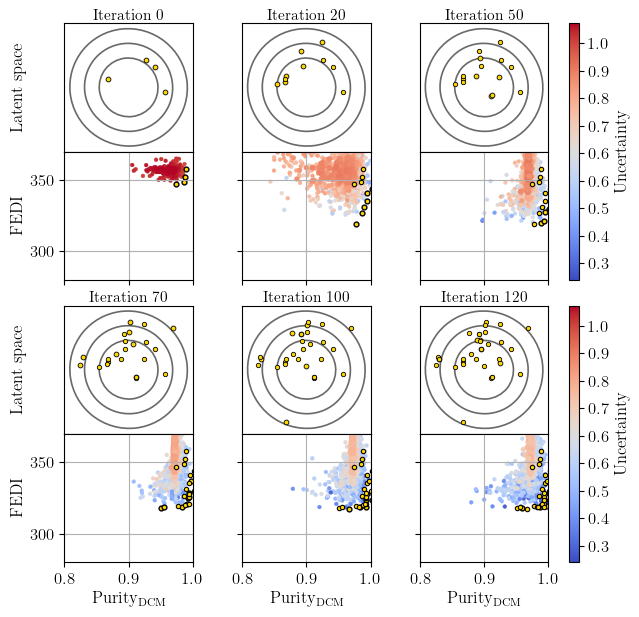

In [50]:
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.gridspec import GridSpec
from scipy.stats import multivariate_normal
import matplotlib.patches as patches
from matplotlib import cm, colors
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker


# ----------------------------
# Parámetros básicos
iterations_sorted = np.array([1, 21, 51, 71, 101, 121])
cmap_name = "coolwarm"

# ----------------------------
# Figura con columna extra para colorbar
# ----------------------------
fig = plt.figure(figsize=(7, 7), constrained_layout=False)
gs = GridSpec(nrows=2, ncols=4, figure=fig,
              width_ratios=[1, 1, 1, 0.05],
              wspace=-0.05, hspace=0.10)

# Creamos una subrejilla (2 filas: [latente pequeño, real grande]) dentro de cada celda principal
latent_axes = []
real_axes = []
for r in range(2):
    for c in range(3):
        cell = gs[r, c].subgridspec(2, 1, height_ratios=[1, 1], hspace=0.0)
        ax_lat = fig.add_subplot(cell[0, 0])  # arriba: espacio latente (mini)
        ax_real = fig.add_subplot(cell[1, 0]) # abajo: espacio real (principal)
        latent_axes.append(ax_lat)
        real_axes.append(ax_real)

# Eje de colorbar ocupando ambas filas
cax_top = fig.add_subplot(gs[0, 3])  # barra para la fila superior
cax_bot = fig.add_subplot(gs[1, 3])  # barra para la fila inferior

# ----------------------------
# Normalización global del color (u = sqrt(sigma1 * sigma2))
mins, maxs = [], []
for i in iterations_sorted:
    g = np.sqrt(df1.loc[df1['iteration'] == i].iloc[:, 2] * df1.loc[df1['iteration'] == i].iloc[:, 3])
    if len(g):
        mins.append(np.nanmin(g))
        maxs.append(np.nanmax(g))
vmin = np.nanmin(mins)
vmax = np.nanmax(maxs)
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# ----------------------------
# Dibujar por iteración
# ----------------------------
sc_last = None
def sample_mask(mask, frac=0.5):
    """Devuelve índices de una fracción aleatoria de un grupo"""
    idx = np.where(mask)[0]
    if len(idx) == 0:
        return np.array([], dtype=int)
    n_select = max(1, int(len(idx) * frac))  # al menos 1 si hay datos
    return rng.choice(idx, size=n_select, replace=False)

for ax_lat, ax_real, i in zip(latent_axes, real_axes, iterations_sorted):
    # ---- Filtro de datos para esta iteración
    mask = (df1['iteration'] == i)
    data = df1.loc[mask].to_numpy()
    if data.size == 0:
        # si no hay datos, ocultamos ambos ejes
        ax_lat.set_axis_off()
        ax_real.set_axis_off()
        continue

    # Ahora hay que sacar puntos no dominados y graficarlos
    F_space = data[:,:2].copy()
    F_space[:, 1] = -F_space[:, 1] # Cambiar la carga termica a positiva
    F_space[:, 0] = -F_space[:, 0] # Cambiar la composicion a negativa 
    nds = NonDominatedSorting()  
    front_indices = nds.do(F_space, only_non_dominated_front=True)
    is_pareto = np.zeros(len(data), dtype=bool)
    is_pareto[front_indices] = True
    is_dominated = ~is_pareto

    ## DataFrames resultantes
    NonDominantPoints = data[is_pareto]

    # ---- Espacio real (abajo): coloreado por u
    u = np.sqrt(data[:, 2] * data[:, 3])
    rng = np.random.default_rng(42)
    n_show = 100 
    N = len(data)
    k = min(n_show, N)

    idx = rng.choice(N, size=min(n_show, N), replace=False)
    # idx = np.argsort(u)[:k]

    p_low, p_high = np.percentile(u, [33.3, 66.6])
    mask_low  = u <= p_low
    mask_mid  = (u > p_low) & (u <= p_high)
    mask_high = u > p_high
    rng = np.random.default_rng(42)  # semilla fija para reproducibilidad
    idx_low  = sample_mask(mask_low, frac=0.40)
    idx_mid  = sample_mask(mask_mid, frac=0.05)
    idx_high = sample_mask(mask_high, frac=0.05)
    ax_real.scatter( data[idx_low, 0], -data[idx_low, 1],
        s=8, c=u[idx_low], cmap=cmap_name, norm=norm, linewidths=0.2, label="Low u"   )
    ax_real.scatter( data[idx_mid, 0], -data[idx_mid, 1],
        s=12, c=u[idx_mid], cmap=cmap_name, norm=norm, linewidths=0.2, label="Mid u"  )
    sc_last = ax_real.scatter( data[idx_high, 0], -data[idx_high, 1],
        s=16, c=u[idx_high], cmap=cmap_name, norm=norm, linewidths=0.2, label="High u" )

    ## GRAFICAR ESTOS PUNTOS PERO CON GOLD COLOR
    ax_real.scatter(NonDominantPoints[:,0], -1*NonDominantPoints[:,1],
                    s=12, facecolors='gold', edgecolors='k', linewidths=1.0)  


    ax_real.set_xlim([0.8,1])
    ax_real.set_ylim([280,370])
    ax_real.grid(True, alpha=1.0)
    ax_lat.set_box_aspect(1)  # mismo aspecto a ambas figuras
    ax_real.set_box_aspect(1) # mismo aspecto a ambas figuras
    # ---- Espacio latente (arriba): puntos globales en gris y los de la iteración resaltados
    mu  = emb_all.mean(axis=0)
    cov = np.cov(emb_all, rowvar=False)
    # regulariza por si es casi singular
    cov += 1e-6 * np.eye(2)

    eigvals, eigvecs = np.linalg.eigh(cov)
    angle_rad = np.arctan2(eigvecs[1,1], eigvecs[0,1])
    angle_deg = np.degrees(angle_rad)
    # radios 1σ y 2σ
    for k, label in zip([1.0, 1.5, 2.0], ["1$\sigma$", "1.5$\sigma$" , "2$\sigma$"]):
        width, height = 2*k*np.sqrt(eigvals)
        # angle = np.degrees(np.arctan2(eigvecs[1,1], eigvecs[0,1]))
        ell = patches.Ellipse(mu, width, height, angle=angle_deg,
                            edgecolor="0.35", facecolor="none",
                            linewidth=1.2, alpha=0.9)
        ax_lat.add_patch(ell)

    # ---- Puntos explorados en cada iteración
    mask2 = (df2['iteration'] == i)
    data2 = df2[mask2].copy()
    ax_lat.scatter(data2['t_sne1'], data2['t_sne2'],
                    s=12, facecolors='gold', edgecolors='k', linewidths=0.6)             # iteración resaltada

    ax_lat.set_title(fr"Iteration {i-1}", fontsize=11, pad=2)
    ax_lat.set_xticks([]); ax_lat.set_yticks([])
    for spine in ax_lat.spines.values():
        spine.set_alpha(1.0)

    
    prev_iters = iterations_sorted[iterations_sorted < i]
    for iprev in prev_iters:
        mask_prev = (df1['iteration'] == iprev)
        data_prev = df1.loc[mask_prev].to_numpy()
        if data_prev.size == 0:
            continue
        # Recalcular no dominados para esa iteración previa (idéntico a tu lógica)
        F_prev = data_prev[:, :2].copy()
        F_prev[:, 1] = -F_prev[:, 1]  # carga térmica positiva
        F_prev[:, 0] = -F_prev[:, 0]  # composición negativa
        nds_prev = NonDominatedSorting()
        idx_front_prev = nds_prev.do(F_prev, only_non_dominated_front=True)
        ND_prev = data_prev[idx_front_prev]

        # Plot dorado (más pequeño / con un poco de alpha para no saturar)
        ax_real.scatter(ND_prev[:, 0], -ND_prev[:, 1],
            s=10, facecolors='gold', edgecolors='k', linewidths=0.8,
            alpha=1.0, zorder=2)
        mask_prev2 = (df2['iteration'] == iprev)
        data_prev2 = df2[mask_prev2]
        if len(data_prev2) == 0:
            continue
        ax_lat.scatter(data_prev2['t_sne1'], data_prev2['t_sne2'],
            s=10, facecolors='gold', edgecolors='k', linewidths=0.6,
            alpha=1.0, zorder=2 )

# ----------------------------
# Etiquetas compartidas y limpieza de ejes
# Solo etiquetas X en la fila inferior (real_axes índices 3,4,5) y Y solo en la primera columna (0 y 3)
for j, ax in enumerate(real_axes):
    # Columna 0 (j%3==0): mostrar Y
    if (j % 3) == 0:
        ax.set_ylabel(r'FEDI', fontsize=12)
    else:
        ax.set_ylabel('')
        ax.tick_params(axis='y', labelleft=False)
    # Fila superior (j<3): ocultar X
    if j < 3:
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelbottom=False)
    else:
        ax.set_xlabel(r'Purity$_{\mathrm{DCM}}$', fontsize=12)
latent_axes[0].set_ylabel("Latent space", fontsize=12, labelpad = 28)
latent_axes[3].set_ylabel("Latent space", fontsize=12, labelpad = 28)
# ----------------------------
import matplotlib as mpl
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_name)
mappable.set_array([])
# Colorbar superior
cb1 = fig.colorbar(mappable, cax=cax_top, orientation="vertical")
cb1.set_label(r"Uncertainty", fontsize=12)
cb1.locator = mticker.MaxNLocator(nbins=10) #mticker.FixedLocator(metric_bar.levels)
cb1.formatter = mticker.FormatStrFormatter('%.1f')  # o '%.1f' o '%.0f'
cb1.update_ticks()

# Colorbar inferior (idéntica)
cb2 = fig.colorbar(mappable, cax=cax_bot, orientation="vertical")
cb2.set_label(r"Uncertainty", fontsize=12)
cb2.locator = mticker.MaxNLocator(nbins=10) #mticker.FixedLocator(metric_bar.levels)
cb2.formatter = mticker.FormatStrFormatter('%.1f')  # o '%.1f' o '%.0f'
cb2.update_ticks()
# Ajustes finales
fig.tight_layout()
plt.show()


Extract data ...

In [38]:
z_space_predicted = torch.tensor([MOBO.all_points[:, -MOBO.latent_dim:].numpy()] , dtype=torch.float32)
f1_discrete, f2_discrete, dw_discrete , col_discrete = MOBO.model_enddec.recover(z_space_predicted)
data_all =  torch.cat((MOBO.all_points[:,:3], f1_discrete.unsqueeze(1), 
                          f2_discrete.unsqueeze(1), dw_discrete.unsqueeze(1),
                          col_discrete.unsqueeze(1)), dim=1).numpy()

C:\Users\gabo1\AppData\Local\Temp\ipykernel_13164\1250652674.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  z_space_predicted = torch.tensor([MOBO.all_points[:, -MOBO.latent_dim:].numpy()] , dtype=torch.float32)


Save data for further analysis

In [78]:
df1 = pd.DataFrame(data= MOBO.all_objectives.numpy() , columns=['pureza', 'FEDI'])
df2 = pd.DataFrame(data= data_all , columns=['x1','x2','x3','x4','x5', 'x6', 'x7'] )
df = pd.concat([df1,df2], axis= 1)
df = df.drop_duplicates()
df.to_csv(r'Intensified_MOBO.csv', index=False)  

If you want to test different configurations modify directly the ASPEN file such as distillate ratios. You can also change the solvent to benchmark against DMF.